Saved students.csv with 200 rows


,student_id,name,class,comprehension,attention,focus,retention,assessment_score,engagement_time
0,1000001,Allison Hill,C,92,75,86,70,75,64
1,1000002,Noah Rhodes,B,87,59,69,80,71,47
2,1000003,Angie Henderson,C,89,65,77,76,63,43
3,1000004,Daniel Wagner,C,60,63,57,35,58,35
4,1000005,Cristian Santos,A,69,70,69,76,66,44


                  count         mean        std        min         25%  \
student_id        200.0  1000100.500  57.879185  1000001.0  1000050.75   
comprehension     200.0       72.915  13.870100       32.0       63.00   
attention         200.0       65.220  15.136617       27.0       55.00   
focus             200.0       67.910  17.169328       22.0       56.00   
retention         200.0       66.205  17.697144       20.0       54.75   
assessment_score  200.0       63.465  13.903789       23.0       54.00   
engagement_time   200.0       46.800  22.435390        6.0       31.00   

                        50%         75%        max  
student_id        1000100.5  1000150.25  1000200.0  
comprehension          73.0       84.00      100.0  
attention              66.0       75.00      100.0  
focus                  68.0       79.25      100.0  
retention              67.0       78.25      100.0  
assessment_score       64.0       73.00       97.0  
engagement_time        44.0       61

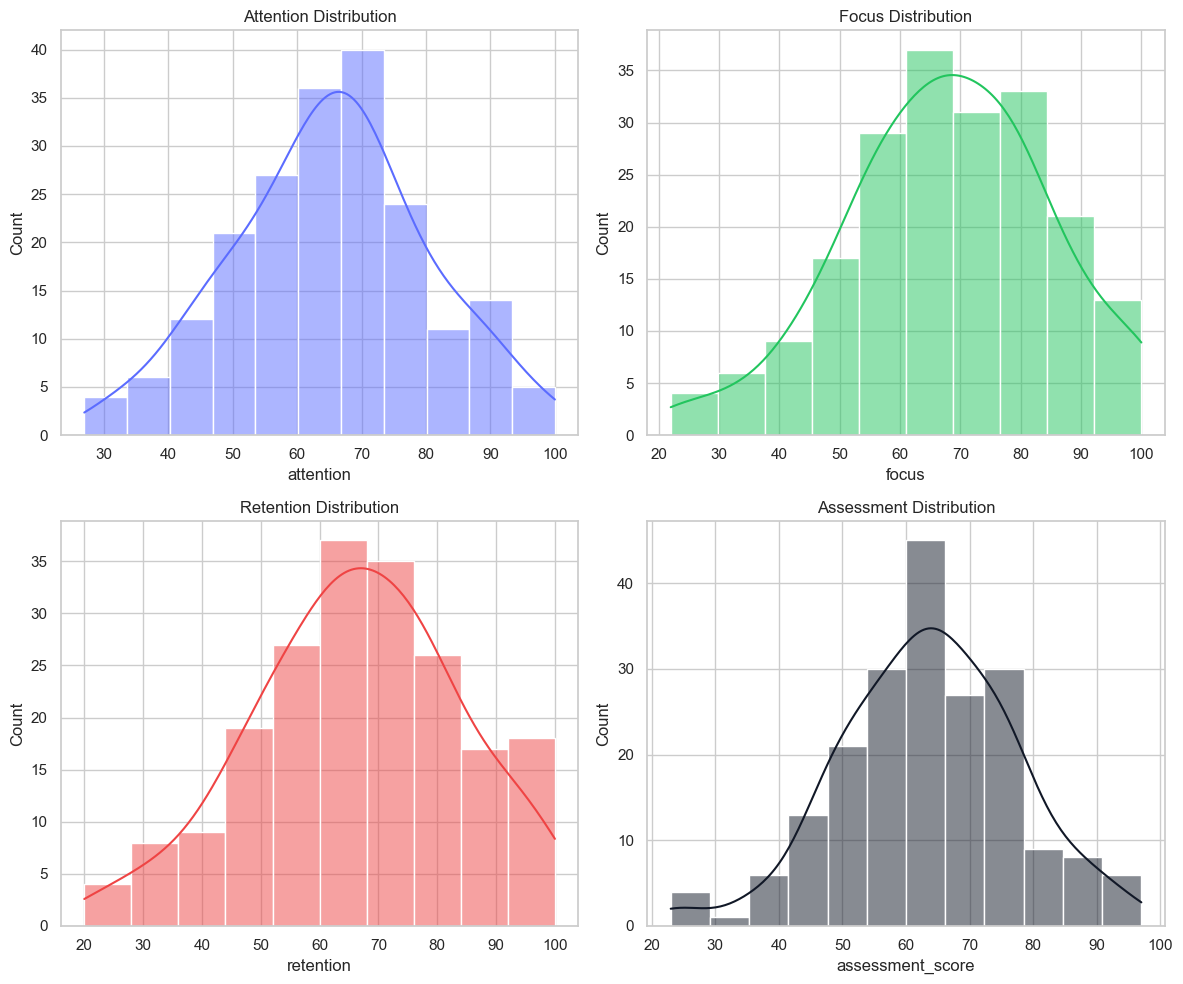

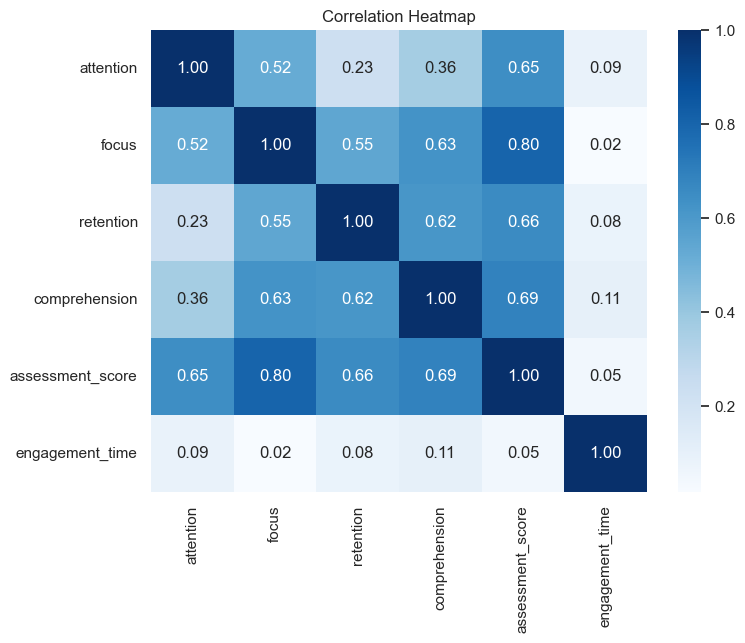

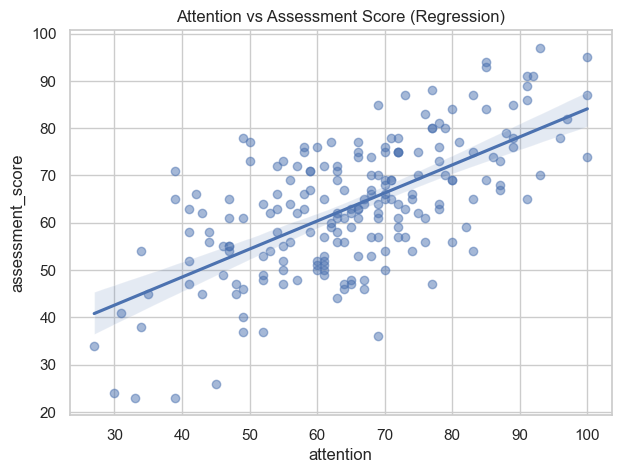

MAE: 5.64 | RMSE: 7.40 | R²: 0.703


C:\Users\Appu Raj\AppData\Local\Temp\ipykernel_24716\1580873547.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


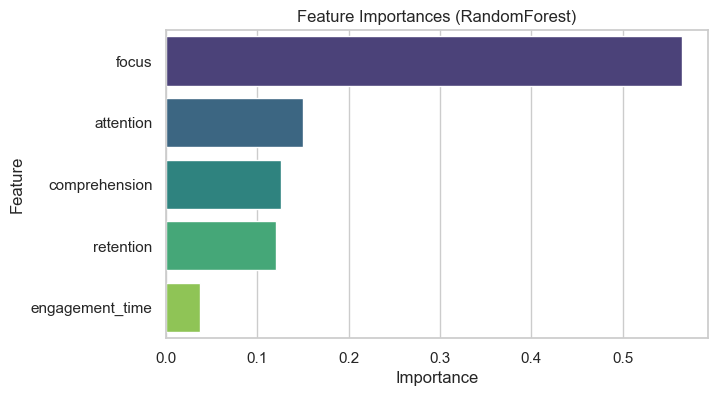

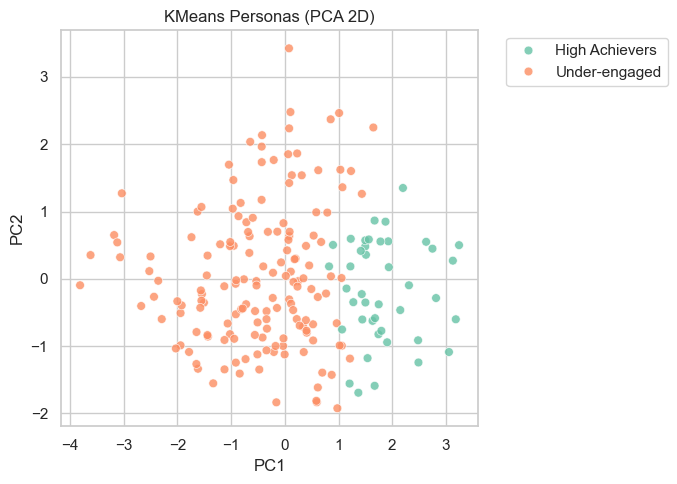

Exported dashboard\public\students.json
Notebook completed successfully.


In [1]:
# Cognitive Skills & Student Performance Analysis
#
# - Generates synthetic dataset (~200 students) with unique student_id, names, classes
# - EDA: summary, distributions, correlations, scatter plot
# - ML: RandomForest regression to predict assessment_score
# - Clustering: KMeans personas + PCA visualization
# - Export: students.csv and dashboard/public/students.json

import os
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Reproducibility
rng = np.random.default_rng(42)
fake = Faker()
Faker.seed(42)

# 1) Data Creation
n_students = 200

classes = rng.choice(['A','B','C'], size=n_students, replace=True, p=[0.34,0.33,0.33])
base_id = 1000001
student_ids = np.arange(base_id, base_id + n_students, dtype=int)

names = [fake.name() for _ in range(n_students)]

# Cognitive skills with realistic correlation structure
attention = np.clip(rng.normal(65, 15, n_students), 0, 100)
focus = np.clip(attention * 0.6 + rng.normal(30, 15, n_students), 0, 100)
retention = np.clip(focus * 0.55 + rng.normal(30, 15, n_students), 0, 100)
comprehension = np.clip((attention*0.2 + focus*0.3 + retention*0.3) + rng.normal(20, 10, n_students), 0, 100)

# Engagement time in minutes, skewed distribution
engagement = np.clip(rng.gamma(shape=4.0, scale=12.0, size=n_students), 5, 180)

# Assessment score influenced by skills and mild noise
assessment = (
    0.25*attention + 0.35*focus + 0.25*retention + 0.10*comprehension + 0.05*np.log1p(engagement)
)
assessment = np.clip(assessment + rng.normal(0, 6, n_students), 0, 100)

# Assemble DataFrame
df = pd.DataFrame({
    'student_id': student_ids,
    'name': names,
    'class': classes,
    'comprehension': np.round(comprehension, 0).astype(int),
    'attention': np.round(attention, 0).astype(int),
    'focus': np.round(focus, 0).astype(int),
    'retention': np.round(retention, 0).astype(int),
    'assessment_score': np.round(assessment, 0).astype(int),
    'engagement_time': np.round(engagement, 0).astype(int),
})

# Ensure unique IDs
assert df['student_id'].is_unique

# Save CSV
csv_path = os.path.join('students.csv')
df.to_csv(csv_path, index=False)
print(f"Saved {csv_path} with {len(df)} rows")

# 2) EDA
display(df.head())
print(df.describe().T)

sns.set(style='whitegrid', context='notebook')
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Distributions
sns.histplot(df['attention'], kde=True, ax=axes[0,0], color='#5b6cff'); axes[0,0].set_title('Attention Distribution')
sns.histplot(df['focus'], kde=True, ax=axes[0,1], color='#22c55e'); axes[0,1].set_title('Focus Distribution')
sns.histplot(df['retention'], kde=True, ax=axes[1,0], color='#ef4444'); axes[1,0].set_title('Retention Distribution')
sns.histplot(df['assessment_score'], kde=True, ax=axes[1,1], color='#111827'); axes[1,1].set_title('Assessment Distribution')
plt.tight_layout()
plt.show()

# Correlations
plt.figure(figsize=(8,6))
corr = df[['attention','focus','retention','comprehension','assessment_score','engagement_time']].corr()
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Scatter: attention vs assessment_score
plt.figure(figsize=(7,5))
sns.regplot(x='attention', y='assessment_score', data=df, scatter_kws={'alpha':0.5})
plt.title('Attention vs Assessment Score (Regression)')
plt.show()

# 3) Machine Learning: Predict assessment_score
features = ['attention','focus','retention','comprehension','engagement_time']
X = df[features].values
y = df['assessment_score'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = math.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

# Feature importances
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(7,4))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Feature Importances (RandomForest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 4) Clustering Personas
persona_features = ['attention','focus','retention','engagement_time']
scaler = StandardScaler()
Xp = scaler.fit_transform(df[persona_features])

kmeans = KMeans(n_clusters=4, n_init=20, random_state=42)
labels = kmeans.fit_predict(Xp)

df['cluster'] = labels

# Map clusters to persona names using centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=persona_features)
# Heuristic persona naming
persona_names = {}
for idx, row in centroids.iterrows():
    att, foc, ret, eng = row['attention'], row['focus'], row['retention'], row['engagement_time']
    if foc > 0.7 and ret > 0.7:
        persona_names[idx] = 'High Achievers'
    elif eng > 0.8 and (att+foc+ret)/3 > 0.2:
        persona_names[idx] = 'Consistent Engagers'
    elif att < 0.0 or foc < 0.0:
        persona_names[idx] = 'Under-engaged'
    else:
        persona_names[idx] = 'Distracted Learners'

df['persona'] = df['cluster'].map(persona_names)

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(Xp)
plt.figure(figsize=(7,5))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=df['persona'], palette='Set2', s=40, alpha=0.8)
plt.title('KMeans Personas (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5) Export to dashboard/public/students.json
export_cols = ['student_id','name','class','comprehension','attention','focus','retention','assessment_score','engagement_time','persona']
export_df = df[export_cols].copy()

# Ensure output directory exists
out_json_dir = os.path.join('dashboard','public')
os.makedirs(out_json_dir, exist_ok=True)
json_path = os.path.join(out_json_dir, 'students.json')

export_df.to_json(json_path, orient='records', indent=2)
print(f"Exported {json_path}")

# Done
print('Notebook completed successfully.')

